In [1]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [2]:
import torch
import wandb
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import uuid

In [3]:
from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

In [4]:
def check_constraints(solution, jobs):
    machine_jobs = [[], []]
    makespans = [0, 0]
    infeasible_count = 0
    
    for job_index, job_assignment in enumerate(solution):
        machine = int(job_assignment)
        job_key = job_index + 1
        job = jobs[job_key]
        machine_jobs[machine].append((job_key, job))
    
    for machine, assigned_jobs in enumerate(machine_jobs):
        current_time = 0
        for job_key, job in sorted(assigned_jobs, key=lambda x: (x[1]['deadline'], x[1]['release'])):
            if current_time < job['release']:
                current_time = job['release']
            current_time += job['duration']
            if current_time > job['deadline']:
                infeasible_count += 1
        makespans[machine] = current_time
    
    if infeasible_count > 0:
        return False, infeasible_count, makespans
    return True, infeasible_count, makespans

def find_extreme_indices(fitnesses, mode='high'):
    if mode not in ['high', 'low']:
        raise ValueError("Mode should be either 'high' or 'low'")

    if mode == 'high':
        extreme_value = max(fitnesses)
    else:
        extreme_value = min(fitnesses)

    return [i for i, value in enumerate(fitnesses) if value == extreme_value]

def convert_tensor_to_unique_np_arrays(tensor):
    np_array = tensor.numpy()
    np_array[np_array == -1] = 0
    unique_arrays = set()
    unique_np_arrays = []
    
    for arr in np_array:
        arr_tuple = tuple(arr)
        if arr_tuple not in unique_arrays:
            unique_arrays.add(arr_tuple)
            unique_np_arrays.append(arr)
    
    unique_np_array = np.array(unique_np_arrays)
    return unique_np_array

def get_solutions(population, fitnesses, mode='low'):
    return convert_tensor_to_unique_np_arrays(population[find_extreme_indices(fitnesses, mode)])

def generate_random_params(base_params):
    return {
        'change_tolerance': random.randint(10, 30),
        'problem_size': base_params['problem_size'],
        'pop_size': random.randrange(1000, 10000, 1000),
        'dropout_prob': round(random.uniform(0.1, 0.3), 1),
        'l1_coef': base_params['l1_coef'],
        'l2_coef': base_params['l2_coef'],
        'learning_rate': round(random.uniform(0.001, 0.005), 3),
        'max_depth': random.randint(4, 8),
        'compression_ratio': round(random.uniform(0.7, 0.9), 1),
        'problem_instance_id': base_params['problem_instance_id'],
        'deepest_only': base_params['deepest_only'],
        'encode': base_params['encode'],
        'repair_solutions': base_params['repair_solutions'],
        'patience': base_params['patience'],
        'delta_mean_population': base_params['delta_mean_population'],
        'check_constraints': base_params['check_constraints'],
        'penalty_mult': random.randint(3, 7)
    }

In [6]:
# Base parameters
base_params = {
    'problem_size': 20,
    'problem_instance_id': 0,
    'deepest_only': True,
    'encode': True,
    'repair_solutions': True,
    'check_constraints': True,
    'delta_mean_population': 0.1,
    'l1_coef': 0.0001,
    'l2_coef': 0.0001,
    'patience': 5
}

# Job definitions
jobs = {
    1: {"duration": 13, "release": 0, "deadline": 100},
    2: {"duration": 23, "release": 5, "deadline": 100},
    3: {"duration": 13, "release": 20, "deadline": 100},
    4: {"duration": 13, "release": 30, "deadline": 100},
    5: {"duration": 13, "release": 35, "deadline": 100},
    6: {"duration": 13, "release": 0, "deadline": 100},
    7: {"duration": 13, "release": 130, "deadline": 150},
    8: {"duration": 13, "release": 0, "deadline": 150},
    9: {"duration": 23, "release": 0, "deadline": 150},
    10: {"duration": 13, "release": 0, "deadline": 150},
    11: {"duration": 10, "release": 0, "deadline": 100},
    12: {"duration": 10, "release": 20, "deadline": 100},
    13: {"duration": 10, "release": 0, "deadline": 100},
    14: {"duration": 20, "release": 0, "deadline": 100},
    15: {"duration": 25, "release": 0, "deadline": 100},
    16: {"duration": 20, "release": 100, "deadline": 120},
    17: {"duration": 10, "release": 0, "deadline": 100},
    18: {"duration": 15, "release": 0, "deadline": 150},
    19: {"duration": 10, "release": 0, "deadline": 150},
    20: {"duration": 20, "release": 0, "deadline": 150},
}

# Parameters
k = 5  # Number of iterations
device = torch.device("cpu")
file_paths = ['../data/qubo/tpp_qubo20.txt']
problem_type = 'QUBO'
use_wandb = True

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: linusrd. Use `wandb login --relogin` to force relogin


Instance has been loaded
Min pop fitness: -22497.0, Mean pop fitness : -22479.96875
Min pop fitness: -22500.0, Mean pop fitness : -22490.71875
Min pop fitness: -22500.0, Mean pop fitness : -22493.81640625
Min pop fitness: -22500.0, Mean pop fitness : -22495.177734375
Min pop fitness: -22500.0, Mean pop fitness : -22495.962890625
Min pop fitness: -22500.0, Mean pop fitness : -22496.478515625
Min pop fitness: -22500.0, Mean pop fitness : -22496.75
Min pop fitness: -22500.0, Mean pop fitness : -22496.953125
Min pop fitness: -22500.0, Mean pop fitness : -22497.052734375
Min pop fitness: -22500.0, Mean pop fitness : -22497.146484375
Min pop fitness: -22500.0, Mean pop fitness : -22497.216796875
Min pop fitness: -22500.0, Mean pop fitness : -22497.2578125
Min pop fitness: -22500.0, Mean pop fitness : -22497.306640625
Iteration 1 with check_constraints=True completed:
Total feasible solutions: 16
Total infeasible solutions: 0


depth,▁▂▃▄▅▆▇█████
mean_fitness,█▅▃▂▂▂▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▂▃▄▄▅▆▆▇▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22497.30664
min_max_fitness,-22500.0
total_eval,941681
total_feasible_solutions_count,16


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22489.15234375
Min pop fitness: -22500.0, Mean pop fitness : -22496.921875
Min pop fitness: -22500.0, Mean pop fitness : -22498.927734375
Min pop fitness: -22500.0, Mean pop fitness : -22499.54296875
Min pop fitness: -22500.0, Mean pop fitness : -22499.7578125
Min pop fitness: -22500.0, Mean pop fitness : -22499.873046875
Min pop fitness: -22500.0, Mean pop fitness : -22499.92578125
Min pop fitness: -22500.0, Mean pop fitness : -22499.953125
Min pop fitness: -22500.0, Mean pop fitness : -22499.966796875
Min pop fitness: -22500.0, Mean pop fitness : -22499.97265625
Min pop fitness: -22500.0, Mean pop fitness : -22499.98046875
Iteration 1 with check_constraints=False completed:
Total feasible solutions: 2
Total infeasible solutions: 1879


depth,▁▂▃▄▅▆▇███
mean_fitness,█▃▂▂▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▃▃▄▅▆▆▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22499.98047
min_max_fitness,-22500.0
total_eval,763552
total_feasible_solutions_count,2


Instance has been loaded
Min pop fitness: -22497.0, Mean pop fitness : -22480.482421875
Min pop fitness: -22500.0, Mean pop fitness : -22492.0
Min pop fitness: -22500.0, Mean pop fitness : -22494.587890625
Min pop fitness: -22500.0, Mean pop fitness : -22495.759765625
Min pop fitness: -22500.0, Mean pop fitness : -22496.341796875
Min pop fitness: -22500.0, Mean pop fitness : -22496.78125
Min pop fitness: -22500.0, Mean pop fitness : -22497.033203125
Min pop fitness: -22500.0, Mean pop fitness : -22497.177734375
Min pop fitness: -22500.0, Mean pop fitness : -22497.3359375
Min pop fitness: -22500.0, Mean pop fitness : -22497.4140625
Min pop fitness: -22500.0, Mean pop fitness : -22497.478515625
Min pop fitness: -22500.0, Mean pop fitness : -22497.55859375
Min pop fitness: -22500.0, Mean pop fitness : -22497.640625
Min pop fitness: -22500.0, Mean pop fitness : -22497.6953125
Iteration 2 with check_constraints=True completed:
Total feasible solutions: 14
Total infeasible solutions: 0


depth,▁▂▄▅▇████████
mean_fitness,█▅▃▃▂▂▂▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▂▃▃▄▅▅▆▆▇▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,6
mean_fitness,-22497.69531
min_max_fitness,-22500.0
total_eval,1348787
total_feasible_solutions_count,14


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22489.603515625
Min pop fitness: -22500.0, Mean pop fitness : -22497.763671875
Min pop fitness: -22500.0, Mean pop fitness : -22499.19140625
Min pop fitness: -22500.0, Mean pop fitness : -22499.59375
Min pop fitness: -22500.0, Mean pop fitness : -22499.77734375
Min pop fitness: -22500.0, Mean pop fitness : -22499.890625
Min pop fitness: -22500.0, Mean pop fitness : -22499.93359375
Min pop fitness: -22500.0, Mean pop fitness : -22499.9609375
Min pop fitness: -22500.0, Mean pop fitness : -22499.97265625
Min pop fitness: -22500.0, Mean pop fitness : -22499.978515625
Min pop fitness: -22500.0, Mean pop fitness : -22499.98046875
Iteration 2 with check_constraints=False completed:
Total feasible solutions: 6
Total infeasible solutions: 1900


depth,▁▂▄▅▇█████
mean_fitness,█▃▂▂▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▃▃▄▅▆▆▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,6
mean_fitness,-22499.98047
min_max_fitness,-22500.0
total_eval,1014341
total_feasible_solutions_count,6


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22470.658203125
Min pop fitness: -22500.0, Mean pop fitness : -22484.037109375
Min pop fitness: -22500.0, Mean pop fitness : -22489.505859375
Min pop fitness: -22500.0, Mean pop fitness : -22491.984375
Min pop fitness: -22500.0, Mean pop fitness : -22493.095703125
Min pop fitness: -22500.0, Mean pop fitness : -22493.673828125
Min pop fitness: -22500.0, Mean pop fitness : -22493.966796875
Min pop fitness: -22500.0, Mean pop fitness : -22494.17578125
Min pop fitness: -22500.0, Mean pop fitness : -22494.404296875
Min pop fitness: -22500.0, Mean pop fitness : -22494.58203125
Min pop fitness: -22500.0, Mean pop fitness : -22494.720703125
Min pop fitness: -22500.0, Mean pop fitness : -22494.95703125
Min pop fitness: -22500.0, Mean pop fitness : -22495.1484375
Min pop fitness: -22500.0, Mean pop fitness : -22495.259765625
Min pop fitness: -22500.0, Mean pop fitness : -22495.380859375
Min pop fitness: -22500.0, Mean pop fi

depth,▁▂▃▄▅▆▇██████████████████████
mean_fitness,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22496.73242
min_max_fitness,-22500.0
total_eval,1152690
total_feasible_solutions_count,12


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22489.306640625
Min pop fitness: -22500.0, Mean pop fitness : -22497.064453125
Min pop fitness: -22500.0, Mean pop fitness : -22498.87890625
Min pop fitness: -22500.0, Mean pop fitness : -22499.564453125
Min pop fitness: -22500.0, Mean pop fitness : -22499.783203125
Min pop fitness: -22500.0, Mean pop fitness : -22499.900390625
Min pop fitness: -22500.0, Mean pop fitness : -22499.943359375
Min pop fitness: -22500.0, Mean pop fitness : -22499.95703125
Min pop fitness: -22500.0, Mean pop fitness : -22499.966796875
Min pop fitness: -22500.0, Mean pop fitness : -22499.974609375
Min pop fitness: -22500.0, Mean pop fitness : -22499.978515625
Iteration 3 with check_constraints=False completed:
Total feasible solutions: 1
Total infeasible solutions: 1362


depth,▁▂▃▄▅▆▇███
mean_fitness,█▄▂▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▃▃▄▅▆▆▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22499.97852
min_max_fitness,-22500.0
total_eval,402995
total_feasible_solutions_count,1


Instance has been loaded
Min pop fitness: -22495.0, Mean pop fitness : -22474.646484375
Min pop fitness: -22500.0, Mean pop fitness : -22489.59375
Min pop fitness: -22500.0, Mean pop fitness : -22492.755859375
Min pop fitness: -22500.0, Mean pop fitness : -22494.01171875
Min pop fitness: -22500.0, Mean pop fitness : -22494.595703125
Min pop fitness: -22500.0, Mean pop fitness : -22494.94921875
Min pop fitness: -22500.0, Mean pop fitness : -22495.1796875
Min pop fitness: -22500.0, Mean pop fitness : -22495.517578125
Min pop fitness: -22500.0, Mean pop fitness : -22495.880859375
Min pop fitness: -22500.0, Mean pop fitness : -22496.099609375
Min pop fitness: -22500.0, Mean pop fitness : -22496.20703125
Min pop fitness: -22500.0, Mean pop fitness : -22496.24609375
Min pop fitness: -22500.0, Mean pop fitness : -22496.37109375
Min pop fitness: -22500.0, Mean pop fitness : -22496.564453125
Min pop fitness: -22500.0, Mean pop fitness : -22496.697265625
Min pop fitness: -22500.0, Mean pop fitne

depth,▁▃▆██████████████████
mean_fitness,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,4
mean_fitness,-22496.94727
min_max_fitness,-22500.0
total_eval,5953921
total_feasible_solutions_count,18


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22489.482421875
Min pop fitness: -22500.0, Mean pop fitness : -22498.34765625
Min pop fitness: -22500.0, Mean pop fitness : -22499.5703125
Min pop fitness: -22500.0, Mean pop fitness : -22499.818359375
Min pop fitness: -22500.0, Mean pop fitness : -22499.90625
Min pop fitness: -22500.0, Mean pop fitness : -22499.951171875
Min pop fitness: -22500.0, Mean pop fitness : -22499.970703125
Min pop fitness: -22500.0, Mean pop fitness : -22499.978515625
Min pop fitness: -22500.0, Mean pop fitness : -22499.978515625
Iteration 4 with check_constraints=False completed:
Total feasible solutions: 0
Total infeasible solutions: 2498


depth,▁▃▆█████
mean_fitness,█▃▂▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁
total_eval,▁▂▃▄▅▆▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,4
mean_fitness,-22499.97852
min_max_fitness,-22500.0
total_eval,2304106
total_feasible_solutions_count,0


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22467.35546875
Min pop fitness: -22500.0, Mean pop fitness : -22479.73828125
Min pop fitness: -22500.0, Mean pop fitness : -22484.98046875
Min pop fitness: -22500.0, Mean pop fitness : -22487.98046875
Min pop fitness: -22500.0, Mean pop fitness : -22489.708984375
Min pop fitness: -22500.0, Mean pop fitness : -22490.77734375
Min pop fitness: -22500.0, Mean pop fitness : -22491.65234375
Min pop fitness: -22500.0, Mean pop fitness : -22492.203125
Min pop fitness: -22500.0, Mean pop fitness : -22492.5703125
Min pop fitness: -22500.0, Mean pop fitness : -22492.8203125
Min pop fitness: -22500.0, Mean pop fitness : -22493.01953125
Min pop fitness: -22500.0, Mean pop fitness : -22493.193359375
Min pop fitness: -22500.0, Mean pop fitness : -22493.302734375
Min pop fitness: -22500.0, Mean pop fitness : -22493.45703125
Min pop fitness: -22500.0, Mean pop fitness : -22493.59765625
Min pop fitness: -22500.0, Mean pop fitness : 

depth,▁▂▃▄▅▆▇█████████████████████
mean_fitness,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22495.31445
min_max_fitness,-22500.0
total_eval,2905236
total_feasible_solutions_count,16


Instance has been loaded
Min pop fitness: -22500.0, Mean pop fitness : -22488.3515625
Min pop fitness: -22500.0, Mean pop fitness : -22495.203125
Min pop fitness: -22500.0, Mean pop fitness : -22497.708984375
Min pop fitness: -22500.0, Mean pop fitness : -22498.783203125
Min pop fitness: -22500.0, Mean pop fitness : -22499.349609375
Min pop fitness: -22500.0, Mean pop fitness : -22499.6171875
Min pop fitness: -22500.0, Mean pop fitness : -22499.7578125
Min pop fitness: -22500.0, Mean pop fitness : -22499.845703125
Min pop fitness: -22500.0, Mean pop fitness : -22499.890625
Min pop fitness: -22500.0, Mean pop fitness : -22499.9140625
Min pop fitness: -22500.0, Mean pop fitness : -22499.935546875
Min pop fitness: -22500.0, Mean pop fitness : -22499.943359375
Iteration 5 with check_constraints=False completed:
Total feasible solutions: 0
Total infeasible solutions: 3218


depth,▁▂▃▄▅▆▇████
mean_fitness,█▄▃▂▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▂▂▃▄▅▅▆▇▇█
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,8
mean_fitness,-22499.94336
min_max_fitness,-22500.0
total_eval,1157880
total_feasible_solutions_count,0


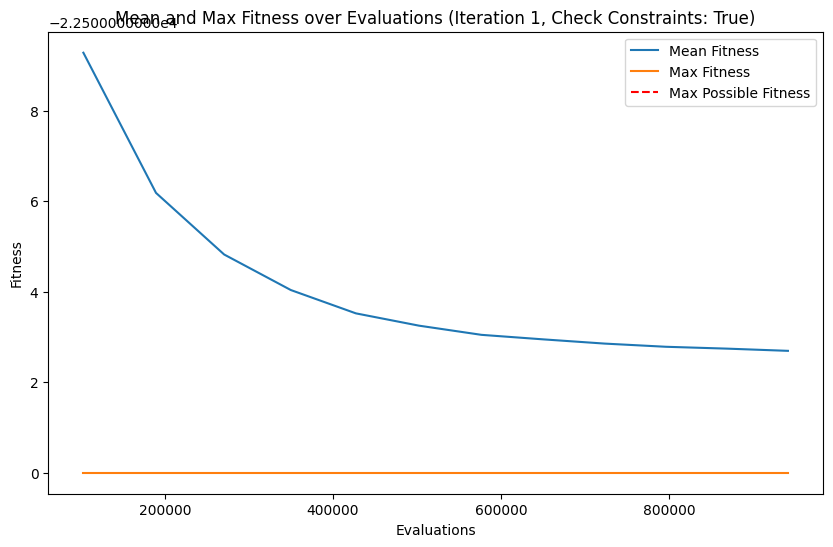

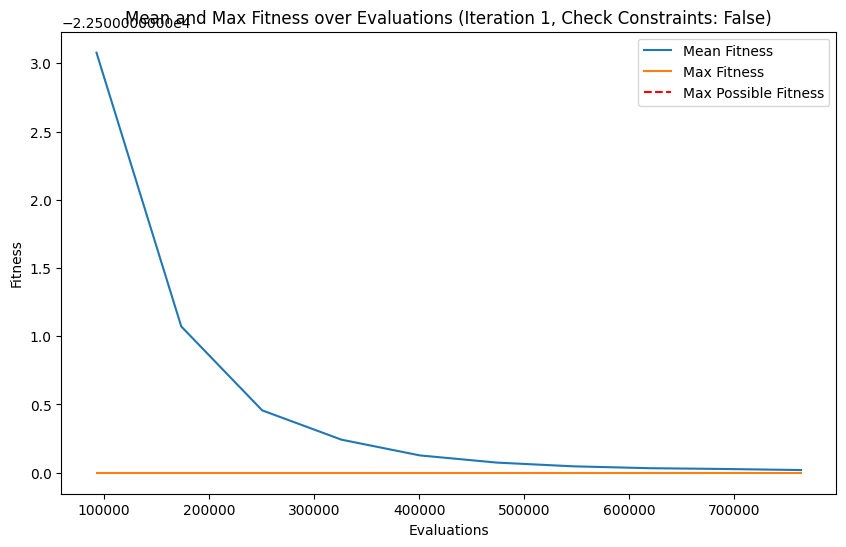

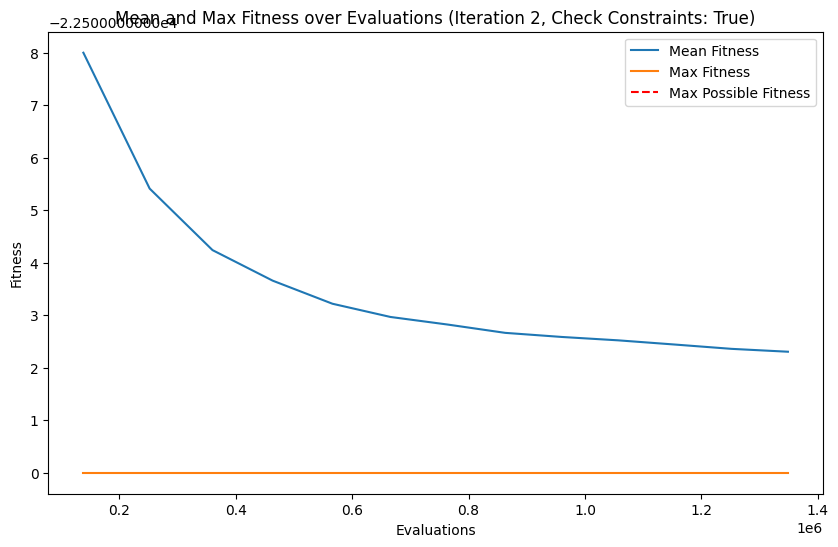

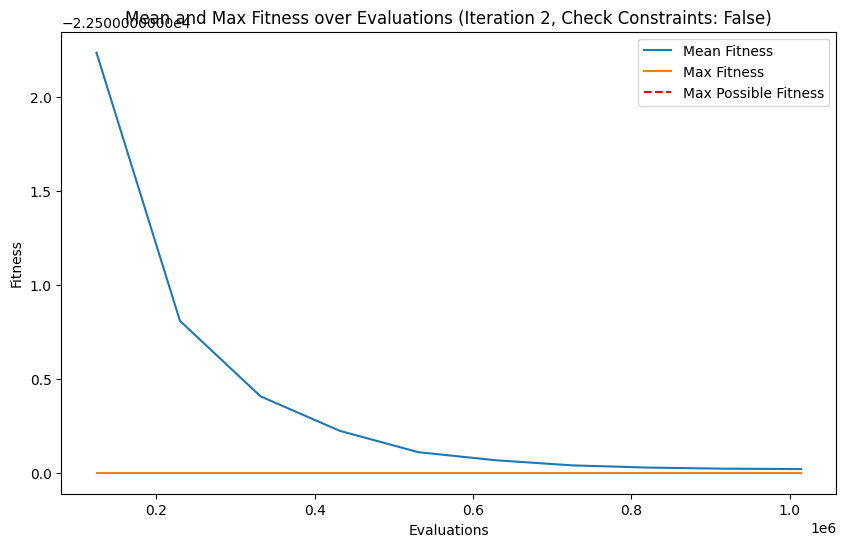

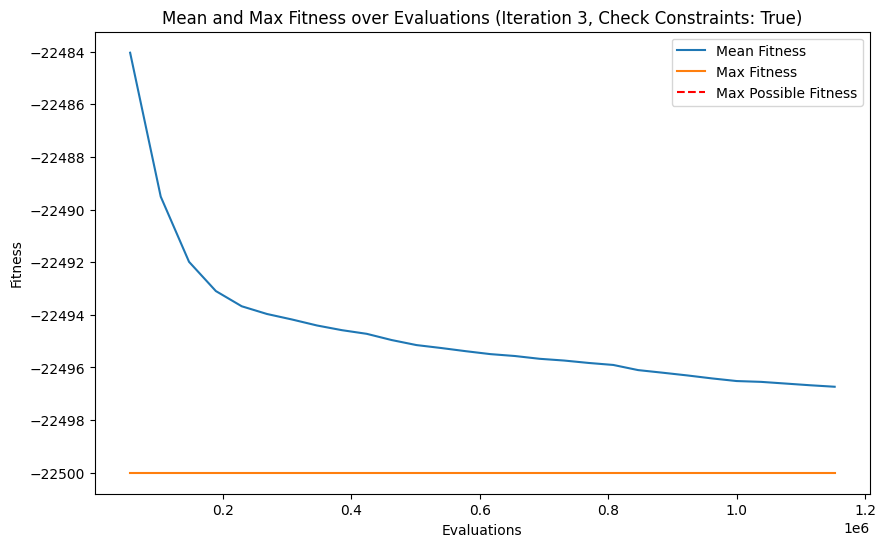

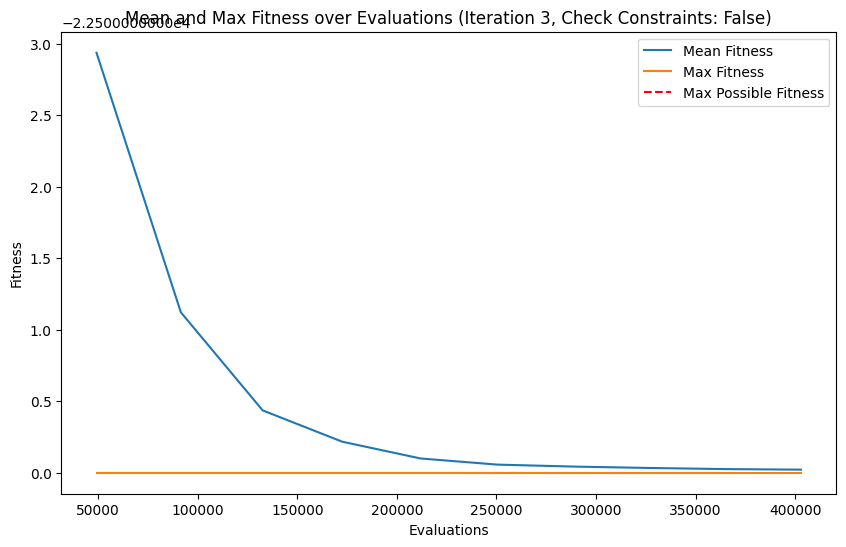

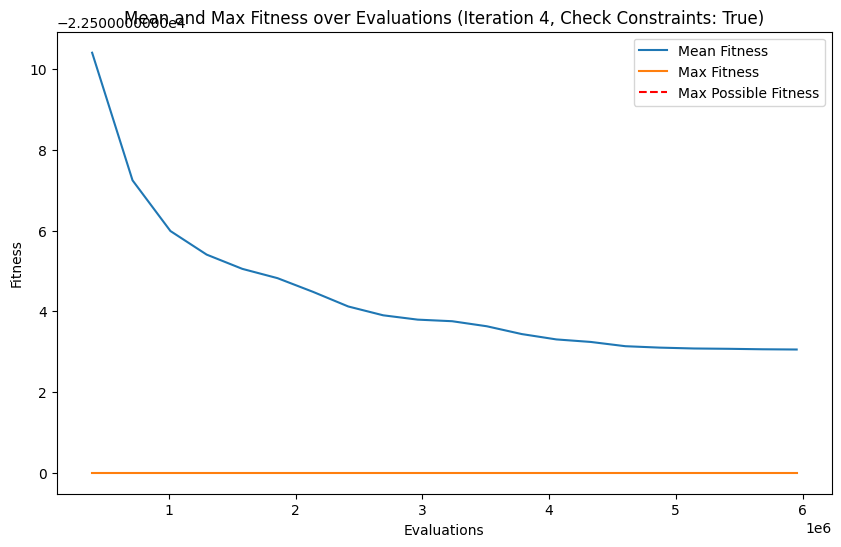

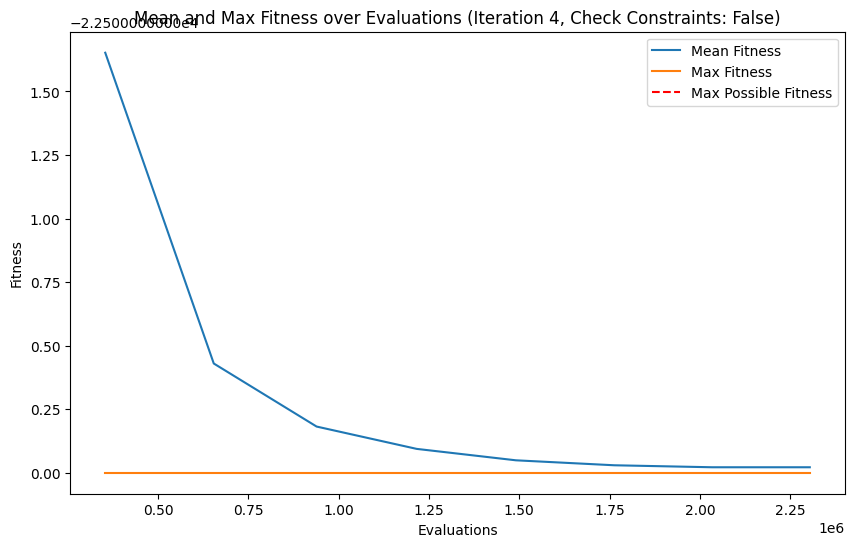

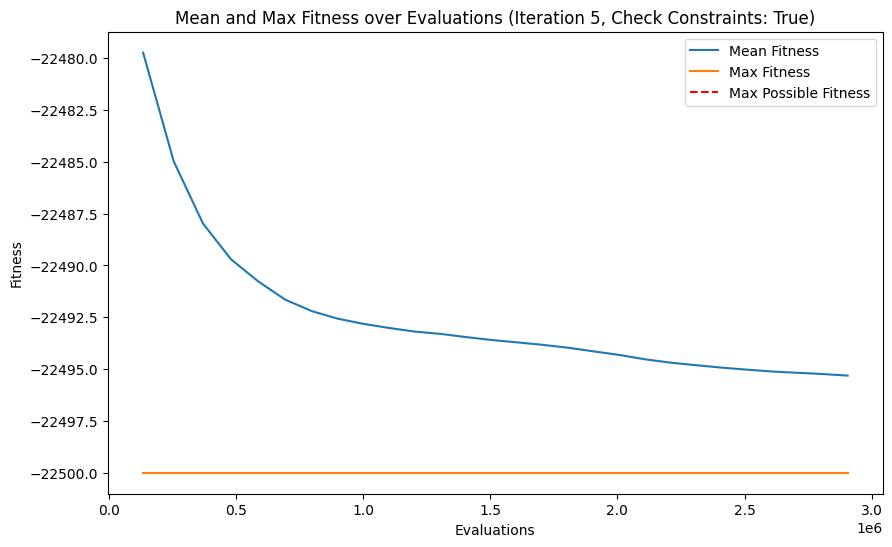

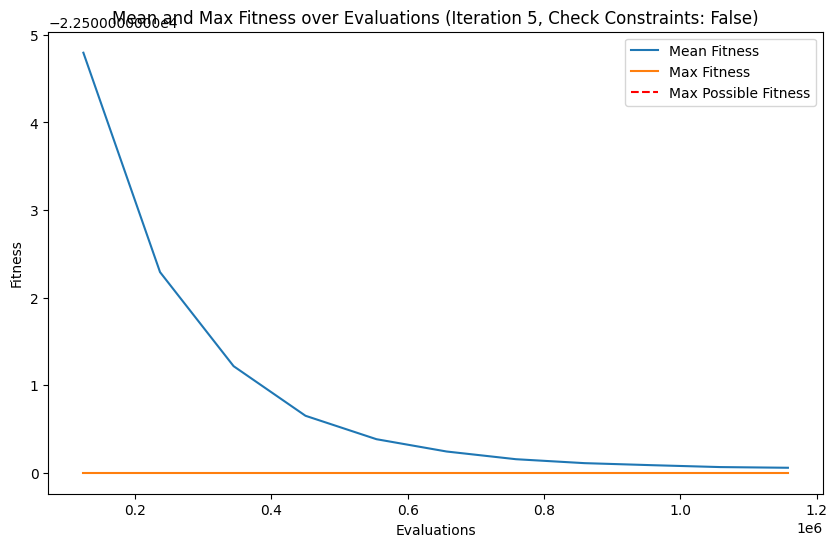

In [7]:
for iteration in range(k):
    base_params['check_constraints'] = True
    params = generate_random_params(base_params)
    unique_id = uuid.uuid4().hex  # Generate a unique ID for the pair

    for check_constraints_flag in [True, False]:
        params['check_constraints'] = check_constraints_flag
        
        if use_wandb:
            wandb.init(project="Deep Optimization with Constraints", tags=[problem_type, f"check_constraints={check_constraints_flag}", f"id={unique_id}"], name=f"run_{iteration + 1}_{check_constraints_flag}")
            wandb.config.update(params)
            wandb.log_artifact(file_paths[0], type='dataset')

            job_params_path = 'job_params.json'
            with open(job_params_path, 'w') as f:
                json.dump(jobs, f)
            wandb.log_artifact(job_params_path, type='dataset')

        if problem_type == 'QUBO':
            problem = QUBO(file_paths[0], params['problem_instance_id'], device)
            if params['check_constraints']:
                problem.jobs = jobs
        elif problem_type == 'MKP':
            problem = MKP(file_paths[0], file_paths[1], params['problem_instance_id'], device)
        else:
            raise ValueError("Unsupported problem type")

        model = DOAE(params['problem_size'], params['dropout_prob'], device)
        handler = OptimAEHandler(model, problem, device)
        
        population, fitnesses = handler.generate_population(params['pop_size'], params['check_constraints'], params['penalty_mult'])
        population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, params['change_tolerance'], params['check_constraints'], params['penalty_mult'])
        handler.print_statistics_min(fitnesses)

        total_eval = 0
        depth = 0

        mean_fitnesses = []
        min_max_fitnesses = []
        total_evaluations = []
        mean_fitness_changes = []

        while True:
            if depth < params['max_depth']:
                hidden_size = round(params['problem_size'] * params['compression_ratio'])
                model.transition(hidden_size)
                depth += 1
                optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['l2_coef'])
            
            handler.learn_from_population(population, optimizer, l1_coef=params['l1_coef'], batch_size=params['pop_size'])
            
            population, fitnesses, evaluations, done = handler.optimise_solutions_min(
                population, fitnesses, params['change_tolerance'], encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only'], 
                check_constraints=params['check_constraints'], penalty_mult=params['penalty_mult']
            )
            handler.print_statistics_min(fitnesses)

            mean_fitness = fitnesses.mean().item()
            min_max_fitness = fitnesses.min().item()
            total_eval += evaluations

            mean_fitnesses.append(mean_fitness)
            min_max_fitnesses.append(min_max_fitness)
            total_evaluations.append(total_eval)

            if use_wandb:
                wandb.log({
                    "mean_fitness": mean_fitness,
                    "min_max_fitness": min_max_fitness,
                    "total_eval": total_eval,
                    "depth": depth
                })

            if len(mean_fitnesses) > 1:
                mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
                mean_fitness_changes.append(mean_fitness_change)
                
                if len(mean_fitness_changes) >= params['patience']:
                    recent_changes = mean_fitness_changes[-params['patience']:]
                    if all(change < params['delta_mean_population'] for change in recent_changes):
                        break
            
            if done:
                break

        plt.figure(figsize=(10, 6))
        plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
        plt.plot(total_evaluations, min_max_fitnesses, label='Max Fitness')
        plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
        plt.xlabel('Evaluations')
        plt.ylabel('Fitness')
        plt.title(f'Mean and Max Fitness over Evaluations (Iteration {iteration + 1}, Check Constraints: {check_constraints_flag})')
        plt.legend()

        if use_wandb:
            wandb.log({"fitness_plot": wandb.Image(plt)})

        solutions = get_solutions(population, fitnesses, mode='low')
        total_feasible_solutions = 0
        total_infeasible_solutions = 0
        logs = []

        for i, solution in enumerate(solutions):
            feasible, infeasible_jobs, makespans = check_constraints(solution, jobs)
            if feasible:
                total_feasible_solutions += 1
            else:
                total_infeasible_solutions += 1
            
            logs.append({
                'solution_number': i + 1,
                'feasible': feasible,
                'infeasible_jobs': infeasible_jobs,
                'makespans': makespans
            })

        if use_wandb:
            wandb.log({
                'solutions': logs,
                'total_feasible_solutions_count': total_feasible_solutions,
                'total_infeasible_solutions': total_infeasible_solutions
            })

        print(f'Iteration {iteration + 1} with check_constraints={check_constraints_flag} completed:')
        print(f'Total feasible solutions: {total_feasible_solutions}')
        print(f'Total infeasible solutions: {total_infeasible_solutions}')

        if use_wandb:
            wandb.finish()